In [18]:
# Goal: Topic models with NMF and LDA (Scikit-learn)
# Result: implementations of topic models in NMF and LDA (a comparison)
# Output: document-word matrices
# Resource: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda
# Resource: 
# Resource: https://github.com/derekgreene/topic-model-tutorial/
# TO DO: refine text processing (stopwords; n-grams, lemmatization); re-iterate w/beta-loss
# TO DO: word clouds for NMF topics
# TO DO: replicate MALLET outputs (topic list; document-topics)

# Load libraries
from pprint import pprint
import pandas as pd
import numpy as np
from itertools import combinations

import gensim
from gensim.models import FastText

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import wordcloud

In [3]:
# DATA Read in docs (corpus) from csv; use column 'combined'
print("Loading dataset...")
docs = pd.read_csv("data/ERI-combined-2009-2019.csv")
docs['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
data = docs['combined']
print(data[:1])
# data_samples = data[:n_samples]
# len(data_samples)

Loading dataset...
0    Streams and Urbanization Urbanization encompas...
Name: combined, dtype: object


In [4]:
# DATA text processing
# To do: refine stop words, re-run
raw_documents = []
snippets = []
for line in data:
    text = line.strip()
    raw_documents.append( line.strip().lower() ) # Read the documents from the input file again
    snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

custom_stop_words = []
#with open( "mallet-2.0.8/stoplists/en-custom.txt", "r" ) as fin: #load custom stop word list
with open( "mallet-2.0.8/stoplists/en.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

print(raw_documents[:1])
print(custom_stop_words[:10])

Read 3770 raw text documents
Stopword list has 524 entries
['streams and urbanization urbanization encompasses a diverse array of watershed alterations that influence the physical, chemical, and biological characteristics of streams. in this chapter, we summarize lessons learned from the last half century of research on urban streams and provide a critique of various mitigation strategies, including recent approaches that explicitly address geomorphic processes. we focus first on the abiotic conditions (primarily hydrologic and geomorphic) and their changes in streams that accompany urbanization, recognizing that these changes may vary with geomorphic context and climatic region. we then discuss technical approaches and limitations to (1) mitigating water-quantity and water-quality degradation through site design, riparian protection, and structural stormwater-management strategies; and (2) restoring urban streams in those watersheds where the economic, social, and political contexts c

In [5]:
# Pass in the same preprocessing parameters
# To do: build n-grams, lemmatize text with vectorizer (https://scikit-learn.org/stable/modules/feature_extraction.html)
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

# look at the terms with the highest TF-IDF scores across all documents
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

# display a ranking of the top 20 terms
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

Created 3770 X 16100 TF-IDF-normalized document-term matrix
Vocabulary has 16100 distinct terms
01. data (72.55)
02. water (68.59)
03. species (67.42)
04. climate (64.61)
05. model (59.18)
06. soil (54.52)
07. snow (48.71)
08. change (47.67)
09. high (44.43)
10. surface (44.21)
11. based (42.98)
12. models (41.48)
13. ocean (38.30)
14. carbon (38.21)
15. spatial (37.74)
16. land (37.37)
17. results (36.83)
18. global (36.81)
19. california (36.53)
20. environmental (36.39)


In [7]:
# Save the document-term matrix, terms, and snippets for later use
from sklearn.externals import joblib
joblib.dump((A,terms,snippets), "outputs/NMF-articles-raw.pkl")

/Users/saralafia/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['outputs/NMF-articles-raw.pkl']

In [8]:
# TOPIC MODEL: Parameter Selection for NMF
# Create the Topic Models
kmin, kmax = 2, 100 # specify an initial range of "sensible" values
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=4

In [9]:
# Parameter Selection for NMF
# Build a Word Embedding (with Word2Vec | FastText) in Gensim
# Resolved issue where stop words were "not found" in embedding model

# Define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            
# Build a Skipgram Word2Vec model from all documents in the input file using Gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 1000 dimensions, the minimum document-term frequency is 2
w2v_model = gensim.models.Word2Vec(docgen, size=1000, min_count=2, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("outputs/NMF-w2v-model.bin")
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
#print(w2v_model['climate'])
#'using' in w2v_model.wv.vocab
#words = sorted(w2v_model.wv.vocab.keys())
#print("Number of words:", len(words))

#w2v_model.most_similar(positive=['climate', 'change'], negative=['soil'], topn=10)
#w2v_model.save('w2v_model.model')

# Once a model is saved, it can be later loaded back to memory and trained with more sentences
# model = gensim.models.Word2Vec.load('model1')
# model.train(more_sentences)

# Build a FastText model as an alternative approach to word embedding
# ft_model = FastText(raw_documents, size=500, window=5, min_count=2, workers=4, sg=1)
# print( "Model has %d terms" % len(ft_model.wv.vocab) )
# sim = ft_model.wv.most_similar("climate")
# print(sim)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 18998 terms


In [10]:
# Parameter Selection for NMF
# Use Word2Vec model to calculate coherence scores for each of these models

# coherence score
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

# get the topic descriptor (i.e. list of top terms) for each topic
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

# process each of the models for different values of k
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=02: Coherence=0.4116
K=03: Coherence=0.4093
K=04: Coherence=0.4661
K=05: Coherence=0.5010
K=06: Coherence=0.5196
K=07: Coherence=0.5573
K=08: Coherence=0.5824
K=09: Coherence=0.5962
K=10: Coherence=0.6182
K=11: Coherence=0.6032
K=12: Coherence=0.6365
K=13: Coherence=0.6238
K=14: Coherence=0.6275
K=15: Coherence=0.6276
K=16: Coherence=0.6429
K=17: Coherence=0.6472
K=18: Coherence=0.6597
K=19: Coherence=0.6630
K=20: Coherence=0.6612
K=21: Coherence=0.6690
K=22: Coherence=0.6593
K=23: Coherence=0.6692
K=24: Coherence=0.6691
K=25: Coherence=0.6692
K=26: Coherence=0.6598
K=27: Coherence=0.6647
K=28: Coherence=0.6736
K=29: Coherence=0.6758
K=30: Coherence=0.6824
K=31: Coherence=0.6837
K=32: Coherence=0.6859
K=33: Coherence=0.6795
K=34: Coherence=0.6838
K=35: Coherence=0.6922
K=36: Coherence=0.6880
K=37: Coherence=0.6937
K=38: Coherence=0.6916
K=39: Coherence=0.6880
K=40: Coherence=0.6934
K=41: Coherence=0.6921
K=42: Coherence=0.6920
K=43: Coherence=0.6897
K=44: Coherence=0.6879
K=45: Coher

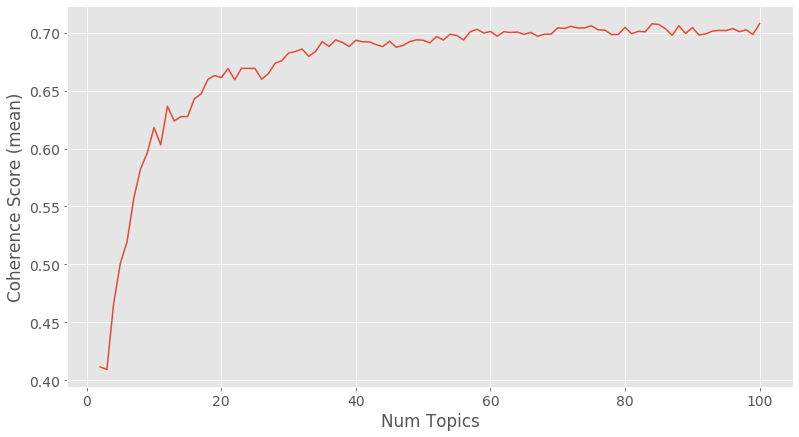

In [15]:
# Generate a line plot of the coherence scores
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
#ax = plt.plot( k_values, coherences )
#ax.grid(False)
#ax.patch.set_alpha(0.5)
#plt.xticks(k_values)
# add the points
plt.plot( k_values, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score (mean)")
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
#plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()
#plt.savefig('figures/NMF-coherence.png')

In [16]:
# Examine the final model (topic number = 97)
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

# topic descriptors for this model
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: water, availability, scarcity, riparian, vapor, quality, resources, subsurface, transpiration, dew
Topic 02: ma, zircon, ca, age, ages, early, dates, formation, arc, metamorphism
Topic 03: snow, cover, albedo, modis, grain, fractional, covered, snowpack, canopy, mountain
Topic 04: soil, moisture, smap, m3, band, roughness, surface, algorithm, rm, observations
Topic 05: ocean, color, optical, satellite, products, algorithms, pnb, merged, blooms, bio
Topic 06: species, habitat, abundance, richness, tree, distribution, slr, extinction, distributions, occupancy
Topic 07: fault, slip, faults, zone, earthquake, geometry, km, strike, earthquakes, san
Topic 08: monazite, pb, zircon, laser, ablation, garnet, dates, metamorphism, ages, titanite
Topic 09: spectral, endmember, mesma, imaging, infrared, spectra, hyperspectral, mapping, mixture, aviris
Topic 10: climate, change, future, impacts, global, chapter, projections, projected, responses, regional
Topic 11: sediment, transport, hg,

In [17]:
# Examine the final model (other topic numbers, e.g. 76, 21...)
k = 20
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

# topic descriptors for this model
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: climate, change, adaptation, models, future, impacts, land, model, responses, scenarios
Topic 02: fault, slip, faults, deformation, basin, rates, zone, uplift, fold, earthquake
Topic 03: snow, swe, cover, snowmelt, equivalent, snowpack, model, albedo, covered, sierra
Topic 04: soil, moisture, microbial, soils, plant, dry, microwave, surface, roughness, smap
Topic 05: ocean, phytoplankton, color, optical, cdom, satellite, data, particle, global, carbon
Topic 06: species, diversity, plant, richness, native, biodiversity, communities, biomass, ecosystem, community
Topic 07: rupture, earthquake, seismic, ground, wave, motion, velocity, model, waves, earthquakes
Topic 08: ma, rocks, crustal, monazite, metamorphism, crust, zircon, metamorphic, exhumation, deformation
Topic 09: vegetation, data, land, spectral, cover, lst, microwave, surface, based, modis
Topic 10: ice, sea, sheet, antarctic, glacial, ka, greenland, holocene, level, retreat
Topic 11: sediment, erosion, rates, 10be, 

In [11]:
# Define parameters for models
n_samples = 3700 # number of data points (3700 in set)
n_features = 1000 # time complexity is polynomial in NMF
n_components = 10 # number of topics
n_top_words = 20 # N significant words returned

In [12]:
# Return top words from each model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [56]:
# Create a document-word matrix from documents (tf-idf features)
# Load the dataset and vectorize it
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                   stop_words='english',
                                   lowercase = True,
                                   token_pattern = r'\b[a-zA-Z]{3,}\b',
                                   max_df=0.5, # words occur in at least half of documents
                                   min_df=2, # words occur in more than one document
                                   max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(3700, 1000)


In [110]:
# Use term frequency (raw term count) features for LDA
# Convert documents into document-term matrix, possibly as raw counts or in TF-IDF form
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words=custom_stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df=0.5, # words occur in at least half of documents
                                min_df=2, # words occur in more than one document
                                max_features=n_features) # copy same parameters from tfidf_vectorizer
tf = tf_vectorizer.fit_transform(data_samples)
print(tf.shape)
#A = tf_vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
terms = tf_vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))
print(terms[100:120])

Extracting tf features for LDA...
(3700, 1000)
Created 3770 X 1000 document-term matrix
Vocabulary has 1000 distinct terms
['central', 'century', 'challenge', 'challenges', 'change', 'changing', 'channel', 'characteristics', 'characterization', 'characterize', 'characterized', 'chemical', 'china', 'chlorophyll', 'circulation', 'clear', 'climate', 'climatic', 'cloud', 'coast']


In [54]:
# Topic Modeling (NMF) Fit the model (Frobenius norm)
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

nmf_fm = NMF(n_components=n_components, 
          random_state=1,
          alpha=.1, 
          l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_fm, tfidf_feature_names, n_top_words)

# Log likelihood: Higher the better
#print("Log Likelihood: ", nmf_fm.score(tfidf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
#print("Perplexity: ", nmf_fm.perplexity(tfidf))

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=3700 and n_features=1000...

Topics in NMF model (Frobenius norm):
Topic #0: data water use model environmental based using research analysis land spatial energy study results used models project approach information high
Topic #1: mantle crust rocks crustal zircon subduction metamorphism lavas arc metamorphic continental isotopic exhumation monazite deformation high ages dates melting upper
Topic #2: snow swe cover water snowmelt snowpack equivalent model modis microwave covered mountain sierra grain resolution scattering nevada sensing depth remote
Topic #3: soil moisture microbial soils vegetation plant microwave surface dry water organic drought biomass carbon plants algorithm band season nitrogen temperature
Topic #4: ice sea sheet glacial antarctic holocene level arctic shelf ages rise bay past circulation maximum warming early west margin age
Topic #5: species plant diversity native habitat richness biomass e

AttributeError: 'NMF' object has no attribute 'score'

In [51]:
# Topic Modeling (NMF) Fit the model (generalized Kullback-Leibler divergence ~ Probabilistic Latent Semantic Indexing)
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)
tfidf_vectorizer.get_params()

# Log likelihood: Higher the better
print("Log Likelihood: ", lda_tf.score(tfidf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tf.perplexity(tfidf))

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=3700 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: based results use analysis high used environmental different studies including potential model study using models important effects systems data approach
Topic #1: data new high evolution crust age ages crustal rocks deformation lower record mantle isotope continental early history low upper consistent
Topic #2: data based using used algorithm model measurements surface accuracy water accurate remote resolution analysis observations area results method sensing band
Topic #3: carbon high concentrations higher organic activity growth microbial increased low production significantly nanoparticles results soil composition effects concentration exposed different
Topic #4: climate changes change annual water precipitation associated increased america climatic variability nevada patterns central li

In [78]:
# Topic model (LDA) grid search to find best number of topics
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model

# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 
                 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
#print("Model Perplexity: ", best_lda_model.perplexity(tf))

/Users/saralafia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -667324.5189372872


NameError: name 'data_vectorized' is not defined

In [7]:
# Topic Modeling (LDA) Fit the model with found parameters

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

# for TF LDA
lda_tf = LatentDirichletAllocation(n_components=10, 
                                   #n_components=n_components,
                                   max_iter=5,
                                   learning_method='online',
                                   learning_offset=50.,
                                   learning_decay=0.5,
                                   random_state=0)


lda_tf.fit(tf)

# Log likelihood: Higher the better
print("Log Likelihood: ", lda_tf.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tf.perplexity(tf))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tf_feature_names, n_top_words)

# See model parameters
pprint(lda.get_params())

Fitting LDA models with tf features, n_samples=3700 and n_features=1000...
Log Likelihood:  -1944449.5032006903
Perplexity:  567.3650123490625

Topics in LDA model:
Topic #0: research project change climate management environmental program conservation systems development ucsb data global california restoration natural use ecosystem provide understanding
Topic #1: data using model based snow surface vegetation used resolution method satellite spatial analysis remote cover observations measurements spectral models time
Topic #2: soil plant plants nanoparticles effects water soils species leaf high results increased native nitrogen litter effect exposure uptake decomposition stress
Topic #3: carbon production biomass microbial community environmental organic phytoplankton diversity effects processes oil cycle emissions biogeochemical marine communities life global primary
Topic #4: ocean mantle wave source high isotopic data samples isotope seismic lavas element waves oceanic surface tra

NameError: name 'pprint' is not defined

In [8]:
# VISUALIZATION pyLDAvis for LDA model from scikit-learn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer)
pyLDAvis.save_html(vis, 'pyLDAvis/lda-scikitlearn-10.html') #saves pyLDAvis graphs as standalone webpage
vis

/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.073141  0.082564       1        1  14.511509
8      0.113796  0.028918       2        1  13.451547
0      0.184092  0.177205       3        1  11.774393
9      0.020344 -0.001704       4        1  11.052858
3      0.135110 -0.081062       5        1  10.006759
5     -0.151273  0.075583       6        1   9.465218
7     -0.038357 -0.089254       7        1   9.282180
4     -0.071771  0.049201       8        1   9.127804
2      0.051289 -0.260598       9        1   6.798207
6     -0.316371  0.019146      10        1   4.529526, topic_info=    Category         Freq           Term        Total  loglift  logprob
835  Default  1473.000000           soil  1473.000000  30.0000  30.0000
846  Default  2101.000000        species  2101.000000  29.0000  29.0000
977  Default  2616.000000          water  2616.000000  28.0000  28.0000
115  Default  1878.000000        climate  1878.000000  27.0000  27.0000
90   Default  1069.000000         carbon  1069.000000  26.0000  26.0000
610  Default  1039.000000          ocean  1039.000000  25.0000  25.0000
792  Default   846.000000       sediment   846.000000  24.0000  24.0000
767  Default   805.000000          river   805.000000  23.0000  23.0000
322  Default   727.000000          fault   727.000000  22.0000  22.0000
183  Default  3332.000000           data  3332.000000  21.0000  21.0000
645  Default   627.000000          plant   627.000000  20.0000  20.0000
771  Default   487.000000          rocks   487.000000  19.0000  19.0000
663  Default   727.000000  precipitation   727.000000  18.0000  18.0000
831  Default  1072.000000           snow  1072.000000  17.0000  17.0000
688  Default  1018.000000        project  1018.000000  16.0000  16.0000
749  Default  1151.000000       research  1151.000000  15.0000  15.0000
523  Default   562.000000         mantle   562.000000  14.0000  14.0000
175  Default   482.000000          crust   482.000000  13.0000  13.0000
522  Default   709.000000     management   709.000000  12.0000  12.0000
968  Default   850.000000     vegetation   850.000000  11.0000  11.0000
102  Default  1397.000000         change  1397.000000  10.0000  10.0000
79   Default   586.000000        biomass   586.000000   9.0000   9.0000
683  Default   788.000000     production   788.000000   8.0000   8.0000
283  Default  1021.000000  environmental  1021.000000   7.0000   7.0000
981  Default   435.000000           wave   435.000000   6.0000   6.0000
712  Default  1124.000000          rates  1124.000000   5.0000   5.0000
551  Default   437.000000      microbial   437.000000   4.0000   4.0000
828  Default   424.000000           slip   424.000000   3.0000   3.0000
68   Default   697.000000          basin   697.000000   2.0000   2.0000
959  Default   871.000000    variability   871.000000   1.0000   1.0000
..       ...          ...            ...          ...      ...      ...
176  Topic10   294.549933        crustal   345.060558   2.9363  -3.8535
188  Topic10   181.214744          dates   220.892321   2.8966  -4.3392
806  Topic10   265.355689          shear   336.293702   2.8576  -3.9578
175  Topic10   370.421974          crust   482.575086   2.8301  -3.6243
879  Topic10   184.589150     subduction   252.761130   2.7802  -4.3208
315  Topic10    97.252851      extension   134.474974   2.7705  -4.9616
910  Topic10   178.651610        thermal   261.409064   2.7139  -4.3535
199  Topic10   246.738295    deformation   377.098062   2.6704  -4.0306
863  Topic10   106.323499         strain   163.714310   2.6629  -4.8724
162  Topic10   102.696395        cooling   161.883402   2.6395  -4.9071
555  Topic10    92.588854        mineral   148.440480   2.6225  -5.0107
554  Topic10   107.122482         middle   176.518050   2.5951  -4.8649
662  Topic10    96.363750            pre   161.943057   2.5754  -4.9708
671  Topic10   182.665329       pressure   321.859885   2.5281  -4.33